# Introduction to JOLI

[JOLI.jl](https://github.com/slimgroup/JOLI.jl) is a Julia framework for constructing matrix-free linear operators with explicit domain/range type control and applying them in basic algebraic matrix-vector operations. This notebook mainly covers 3 things:

1. How to build a linear operator in JOLI, and verify its correctness.
2. How to solve a linear inverse problem $Ax=b$ where $A$ is a linear operator defined by JOLI.
3. How JOLI interacts with machine learning toolbox [Flux.jl](https://github.com/FluxML/Flux.jl) and optimization toolbox [Optim.jl](https://github.com/JuliaNLSolvers/Optim.jl) via [ChainRules.jl](https://github.com/JuliaDiff/ChainRules.jl).

## Build a linear operator

We start by loading a few packages.

In [1]:
using LinearAlgebra, FFTW, JOLI, JOLI4Flux, PyPlot, Random, IterativeSolvers, GenSPGL, Test;
using JOLI4Flux, Optim, Zygote, ChainRulesCore, Flux;
Random.seed!(4321);

The JOLI toolbox gives a way to represent matrices implicitly. Instead of storing all entries in a matrix, JOLI only needs to store the forward and adjoint actions of this matrix on a vector, and the metadata (domain/range types etc). This is quite important when working with large-scale linear systems, where the linear operator can only be stored in a matrix-free way to fit into memory.

For example, we can construct a convolution operator given its kernel $w$ via JOLI toolbox. We first set up the convolution kernel as below

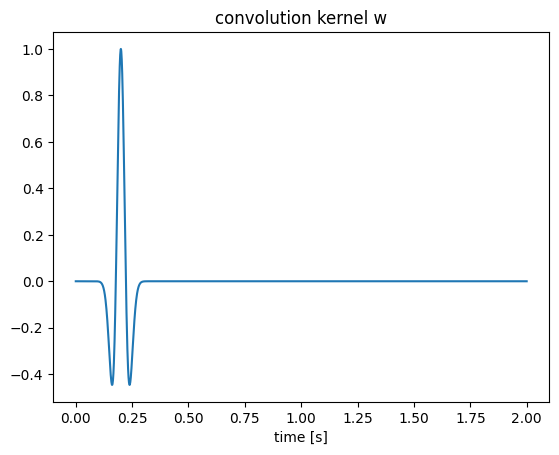

In [2]:
t = 0:.001:2';   # time interval
N = length(t);   # length
w = (1 .-2*1e3*(t .-.2).^2).*exp.(-1e3*(t .-.2).^2);    # convolution kernel
figure();plot(t, w);title("convolution kernel w");xlabel("time [s]");

We know that convolution can be computed easily thanks to Fourier transform---i.e.,

$$\mathcal{F}(w\ast x) = \mathcal{F}(w)\cdot \mathcal{F}(x),$$

where $\mathcal{F}$ denotes the Fourier transform, $\ast$ denotes convolution, and $\cdot$ denotes element-wise multiplication. Therefore, we can use the pre-defined linear operators in JOLI (`joDFT` for Fourier transform and `joDiag` for diagonal matrix) to construct the convolution operator `A` as

In [3]:
F = joDFT(N; DDT=Float64, RDT=ComplexF64);
W = joDiag(fft(w); DDT=ComplexF64, RDT=ComplexF64);
A = F' * W * F;

In general, JOLI provides a variety of linear operators that are frequently used in the scientific computing community, such as restriction operators, compressive sensing matrices, Fourier/wavelet transforms etc to name only a few. If you want to use common linear operators, we suggest you first check the [JOLI reference guide](https://slimgroup.github.io/JOLI.jl/) to find pre-existing ones. In case you want to define something exotic enough that doesn’t exist yet in the JOLI package, you can still construct your own JOLI operator by providing the forward and adjoint actions of the operator. The code block below is a dummy example to demonstrate how to build a linear operator of dense matrix (although there is already `joMatrix` to do this):

In [4]:
M = randn(N, N)
M1 = joLinearFunctionFwd(N, N,  # input and output size
        x -> M * x,                             # forward evaluation
        x -> transpose(M) * x,                  # transpose evaluation
        x -> adjoint(M) * x,                    # adjoint evaluation
        x -> conj(M) * x,                       # conjugate evaluation
        Float64, Float64; name="DIYOp");        # domain and range types, operator name

We can access the types of domain/range and size of `M1` via native julia functions

In [5]:
println("size(M1) is ", size(M1))
println("domain type is ", deltype(M1))
println("range type is ", reltype(M1))

size(M1) is (2001, 2001)
domain type is Float64
range type is Float64


After we define the linear operator `M1`, we should verify its correctness by linearity test and adjoint test

In [6]:
a1 = randn(Float64, N);
a2 = randn(Float64, N);
@test isapprox(M1 * a1 + M1 * a2, M1 * (a1 + a2));        # linearity test
@test isapprox(dot(a1, M1 * a2), dot(M1' * a1, a2));     # adjoint(dot) test

JOLI also provides these testing functions so that it generates the testing vectors and runs the test for you

In [7]:
@test islinear(M1)[1];
@test isadjoint(M1)[1];

In case you've built your own JOLI operator and you find this operator is generally applicable to a broader community, we highly encourage you to open a pull request to add your DIY operator in JOLI.

## Solve $Ax=b$ with the built linear operator

Now we have successfully defined a convolution operator `A` with JOLI toolbox. We can then solve a linear inverse problem

$$Ax=b$$

using iterative solvers. In this tutorial, we set up a ground truth `x` as a sparse vector, and use 2 iterative methods to solve for `x`---[LSQR](https://iterativesolvers.julialinearalgebra.org/stable/linear_systems/lsqr/) and [spgl1](https://friedlander.io/spgl1/). Notice that these iterative methods only require the forward and adjoint evaluations of `A`, which are both provided by our JOLI operator. Thanks to the power of abstraction in Julia, we do not need to overload these iterative algorithms. These julia native algorithms work out of the box.

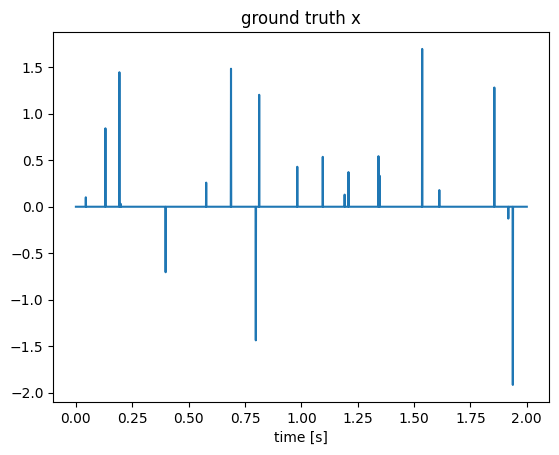

In [8]:
# set up the ground truth x
k = 20;
x = zeros(N);
x[rand(1:N, k)] = randn(k);
figure();plot(t, x);title("ground truth x");xlabel("time [s]");

We then generate a noisy measurement `b` via perturbing the forward evaluation by a noise term `e`.

In [9]:
e = 1e-3 * randn(N);    # noise
b = A * x + e;          # noisy measurement

Then we can first solve for `x` using LSQR in IterativeSolvers.jl package

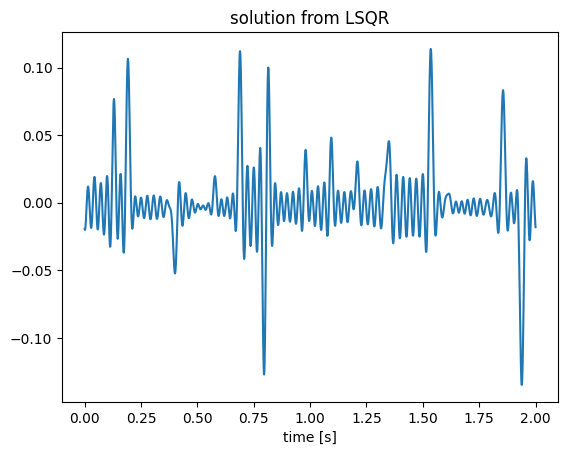

In [10]:
x1 = lsqr(A, b; maxiter=500);
figure();plot(t, x1);title("solution from LSQR");xlabel("time [s]");

We can see the recovery is somehow noisy because the convolution operator has a null space and LSQR searches for a minimal 2-norm solution. Since the ground truth signal is sparse, we can use spgl1 algorithm to solve for `x`, which pursues a sparse solution.

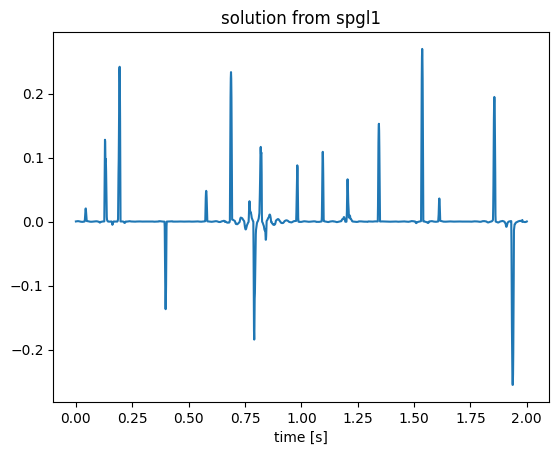

In [11]:
x2, _, _, _ = spgl1(A, b, options = spgOptions(iterations=500, verbosity=0));
figure();plot(t, x2);title("solution from spgl1");xlabel("time [s]");

We can see that spgl1 produces a sparse solution as expected. Notice again that we did not provide a matrix to these algorithms, but a linear operator equipped with forward and adjoint evaluations. `lsqr` and `spgl1` algorithms work right away without any modification.

## Automatic differentiation (AD) through the linear operator

Furthermore, we have the package [JOLI4Flux](https://github.com/slimgroup/JOLI4Flux.jl) that "teaches" Julia how to differentiate through the linear operator---i.e., "teaches" Julia to apply the adjoint of the linear operator during back-propagation. Taking advantage of this AD capability, we can solve the inverse problem $Ax=b$ via different regularization techniques and different objective functions. Since the gradient is provided by AD, we can use any kind of gradient-based optimization algorithm to acquire the solution. In the following example, we adopt a least-squares objective with an $\ell_1$ penalty as

$$\min_{x}\frac{1}{2} \|Ax-b\|_2^2 + \lambda \|x\|_1$$

and we use L-BFGS algorithm from [Optim.jl](https://github.com/JuliaNLSolvers/Optim.jl) package to iteratively invert the linear system.

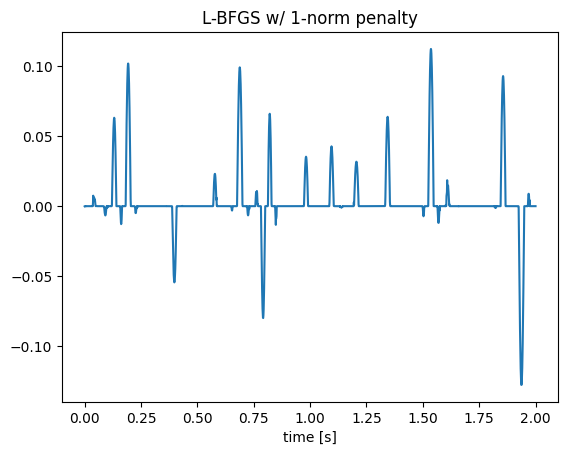

In [12]:
λ = 1;   # weight on l1 regularization
loss(x) = .5 * norm(A * x - b)^2 + λ * norm(x,1);                 # objective function
δloss!(g, x) = begin g.=gradient(loss, x)[1]; return loss(x) end; # in-place gradient function
summary = optimize(loss, δloss!, zeros(N), LBFGS(), Optim.Options(iterations=500));
figure();plot(t, summary.minimizer);title("L-BFGS w/ 1-norm penalty");xlabel("time [s]");

Linear operators in JOLI also talk to deep neural networks in Flux very effectively with the help of JOLI4Flux. We can also reparameterize the input `x` by a network `f` with a fixed input `z` and solve for the network parameters instead---i.e.,

$$\min_{\theta}\|Af_{\theta}(z)-b\|_2^2.$$

This is so-called deep prior approach discussed in [Ulyanov, Dmitry, Andrea Vedaldi, and Victor Lempitsky. "Deep image prior." Proceedings of the IEEE conference on computer vision and pattern recognition. 2018](https://arxiv.org/abs/1711.10925). It has also been adopted into scientific computing and computational geoscience community, where `A` is PDE-based linear operator, such as in [Siahkoohi, Ali, Gabrio Rizzuti, and Felix J. Herrmann. "Deep Bayesian inference for seismic imaging with tasks." arXiv preprint arXiv:2110.04825 (2021)](https://arxiv.org/abs/2110.04825).

In this tutorial, we adopt a dense layer as a very simple deep prior network for demonstrative purpose only. In practice, the deep prior approach might need careful choices on the network structure and regularization parameters. Thanks to the abstraction, we can still write very clean code to interact with Flux and work with optimizers in Flux, such as ADAM.

In [13]:
f = Dense(2*N, N); # a very simple network
z = randn(2*N);    # fixed input
Flux.trainmode!(f, true);
θ = Flux.params(f);  # network parameters

# Optimizer
opt = ADAM(1f-4)
for j=1:500
    grads = gradient(θ) do
        return .5 * norm(A * f(z) - b)^2 + norm(f(z), 1) + norm(θ)^2;
    end

    # Update params
    for p in θ
        Flux.Optimise.update!(opt, p, grads[p])
    end
end


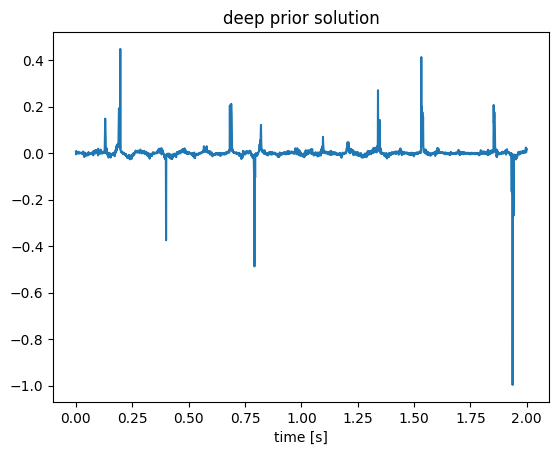

In [14]:
Flux.testmode!(f, true);
figure();plot(t, f(z));title("deep prior solution");xlabel("time [s]");

Thanks to the abstraction power of Julia, multiphysics data-driven framework can be written in a quite clean way in Julia, and can be inverted thanks to the AD capability. More information is available at [Louboutin, Mathias, et al. "Accelerating innovation with software abstractions for scalable computational geophysics." arXiv preprint arXiv:2203.15038 (2022)](https://arxiv.org/pdf/2203.15038.pdf).